* data source:https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification

* (WELFake) is a dataset of 72,134 news articles with 35,028 real and 37,106 fake news. For this, authors merged four popular news datasets (i.e. Kaggle, McIntire, Reuters, BuzzFeed Political) to prevent over-fitting of classifiers and to provide more text data for better ML training.

* Dataset contains four columns: Serial number (starting from 0); Title (about the text news heading); Text (about the news content); and Label (0 = fake and 1 = real).

# Import Libraries and Dataset

In [35]:
import pandas as pd

import numpy as np

from matplotlib.pylab import plt

import seaborn as sns

from collections import Counter

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC

In [2]:
#%pip install wordcloud

In [3]:
from wordcloud import WordCloud

In [4]:
news_df = pd.read_csv(r'/Users/lih-anhsu/Desktop/Sample_Project/phony news detection/WELFake_Dataset.csv')

# Exploratory Data Analysis & Data Cleaning

In [5]:
news_df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [6]:
news_df = news_df.drop(['Unnamed: 0'], axis = 1)

In [7]:
news_df.shape

(72134, 3)

In [8]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [9]:
news_df.isnull().sum()

title    558
text      39
label      0
dtype: int64

extract phony/real news content to see the common used word difference

In [10]:
phony_news = news_df[news_df['label'] == 0]

In [11]:
real_news = news_df[news_df['label'] == 1]

In [12]:
# join title + test, and change it into string
phony_news['all_content'] = phony_news['title'] + phony_news['text']

real_news['all_content'] = real_news['title'] + real_news['text']


/var/folders/7y/pry034n17xs1w4n0rfm69zh00000gn/T/ipykernel_38471/529329107.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phony_news['all_content'] = phony_news['title'] + phony_news['text']
/var/folders/7y/pry034n17xs1w4n0rfm69zh00000gn/T/ipykernel_38471/529329107.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_news['all_content'] = real_news['title'] + real_news['text']


In [13]:
# convert value in col into np array str
all_content_phony = ' '.join(phony_news['all_content'].astype(str).values)

all_content_real = ' '.join(real_news['all_content'].astype(str).values)

## common words in phony news 

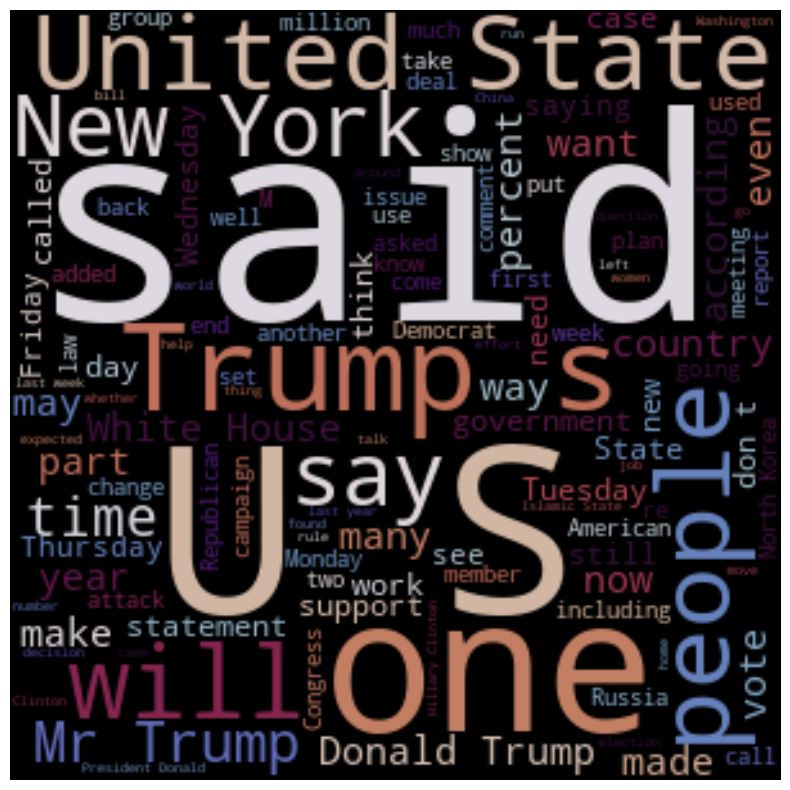

In [40]:
wordcloud = WordCloud(
    background_color='black', 
    max_words=120,
    width=300, 
    height=300,
    colormap='twilight_r'  # Change according to colormap 
).generate(all_content_phony)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## common words in real news

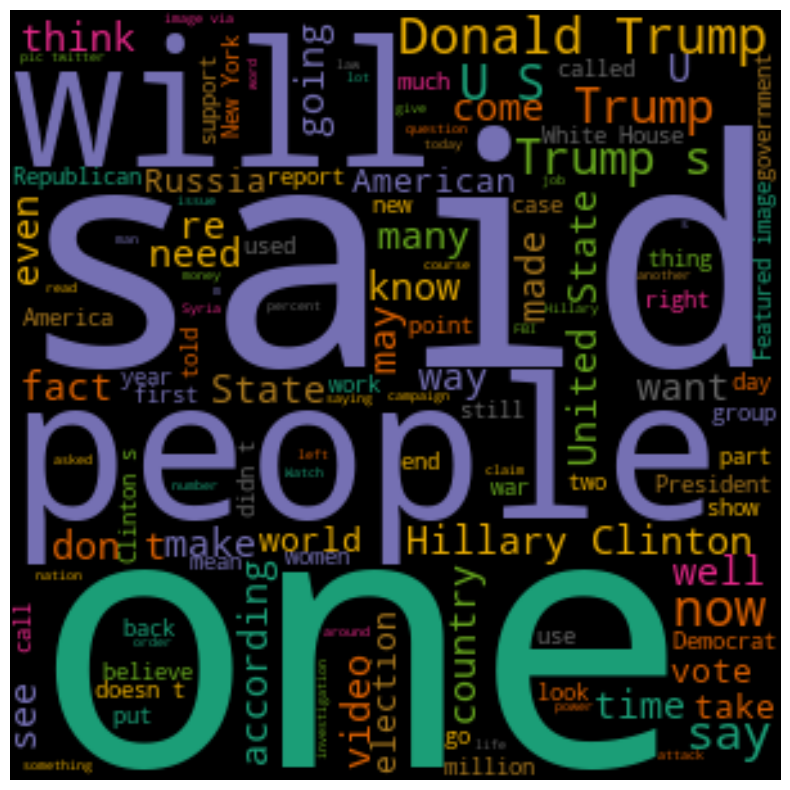

In [41]:
wordcloud = WordCloud(
    background_color='black', 
    max_words=120,
    width=300, 
    height=300,
    colormap='Dark2'
).generate(all_content_real)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

* Phony news often refers to politics-related terms in word clouds.
* Real news often refers to more general topics without specific terms being used too frequently in word clouds.

news_df['label'] is the target to predict, remove it from df and call it y label

In [16]:
y_label = news_df['label']

In [17]:
news_df = news_df.drop(['label'], axis = 1)

In [18]:
# number of real/phony news
y_label.value_counts()

1    37106
0    35028
Name: label, dtype: int64

* 3 columns (title, text, label) and 72134 rows in news_df
* title has 558 nulls, text has 39 nulls
* number of real news is 37106, phony news is 35028

In [19]:
# check how's the null look like in title, text
news_df[news_df['title'].isnull()].head()

,title,text
1,NaN,Did they post their votes for Hillary already?
43,NaN,True. Hillary needs a distraction and what bet...
162,NaN,All eyes on Electoral delegates. The People kn...
185,NaN,Cool
269,NaN,A leading US senator: US Supporting War in Syr...


In [20]:
news_df[news_df['text'].isnull()].head()

,title,text
2457,Après le succès de « Mariés au premier regard ...,NaN
3534,Elections US : les premières estimations donne...,NaN
3709,110% des Américains assurent qu’ils continuero...,NaN
5612,Des millions d’Américains recherchent massivem...,NaN
6270,Vladimir Poutine est élu 45e Président des Eta...,NaN


In [21]:
#fill null since we can't drop null (data size is too small)
news_df = news_df.fillna('')

In [22]:
news_df.isnull().sum()

title    0
text     0
dtype: int64

In [23]:
x = news_df['text']

x_train, x_test, y_train, y_test = train_test_split(x, y_label, test_size = 0.2) #0.2 means 20% is for vaidation

In [24]:
x_train

56559    One of Donald Trump s top advisers repeatedly ...
50636    0 comments \nThe story of what happened to an ...
10631    Dominican newspaper El Nacional had a bit of f...
61481    North Carolina is facing even more backlash fo...
9673     The parents of a 6th grade student at Live Oak...
                               ...                        
65074    The answer to this question should shock every...
61859    Baltimore City State s Attorney Marilyn Mosby ...
34288    Another politician using your money to pay off...
37040    In the first joint press conference between U....
53830    Tune in to the Alternate Current Radio Network...
Name: text, Length: 57707, dtype: object

In [25]:
len(x_train) # 80% is here

57707

In [26]:
len(x_test) # 20% is here, just for checking

14427

# Data Manipulation and Transformation

* vectorize the word content (x train, x test) for ML

In [27]:
vectorizer = TfidfVectorizer(stop_words = 'english', max_df = 0.7)

x_train_vector = vectorizer.fit_transform(x_train) #first time use fit_transform to scale the data, then only use transform after this ton everything  

x_test_vector = vectorizer.transform(x_test)

# Machine Learning Model

In [28]:
# create classifier
clf = LinearSVC()

clf.fit(x_train_vector, y_train) # y train and y test are not text so no need to vectorize further

LinearSVC()

In [29]:
clf.score(x_test_vector, y_test)

0.9575795383655645

95.8 % accuracy

In [30]:
# below means that article among y test, 95.8% is classified correctly 
classified_corrected = len(y_test)*0.95889

total_test_num = len(y_test)

print(f'{classified_corrected} of {total_test_num} is classified correctly')

13833.90603 of 14427 is classified correctly


Confusion Matrix

In [33]:
pred = clf.predict(x_test_vector)

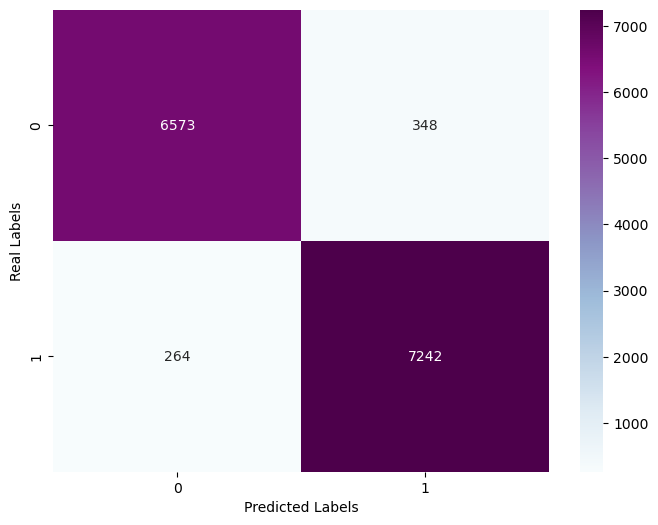

In [43]:
# Create a confusion matrix
cm = confusion_matrix(y_test, pred)

plt.figure(figsize = (8,6))

sns.heatmap(cm, annot=True, 
            fmt='', cmap='BuPu')

plt.xlabel('Predicted Labels')

plt.ylabel('Real Labels'); # the ; remove the output line of result

* row 0 col 0 (top left) means 6573 news are True Negative (TN), predicted as 0 (phony news) correctly 
* row 0 col 1 (top right) means 348 news are False Positive (FP), predicted as 1 (real news) but actually is 0 (phony news)
* row 1 col 0 (bottom left) means 264 news are False Negative (FN), predicted as 0 (phony news) but actually is 1 (real news)
* row 1 col 1 (bottom right) means 7242 news are True Positive (TP), predicted as 1 (real news) correctly 